## Higgs_idx Debug Notebook

### auxiliary

In [1]:
import logging
from pathlib import Path

import awkward as ak
import click
import h5py
import numpy as np
import uproot
import vector

from src.data.delphes.matching import (
    match_fjet_to_jet,
    match_higgs_to_fjet,
    match_higgs_to_jet,
)

In [2]:
vector.register_awkward()
vector.register_numba()
ak.numba.register()

logging.basicConfig(level=logging.INFO)

N_JETS = 10
N_FJETS = 3
MIN_JET_PT = 20
MIN_FJET_PT = 200
MIN_JETS = 6
PROJECT_DIR = Path.cwd().resolve().parents[3]

In [3]:
def to_np_array(ak_array, max_n=10, pad=0):
    return ak.fill_none(ak.pad_none(ak_array, max_n, clip=True, axis=-1), pad).to_numpy()

#### Mimicing main() in this notebook

In [4]:
in_files = Path("/hhh-vol/data/delphes/v2/GF_HHH_SM_c3_0_d4_0_14TeV/").glob("sample_*.root")
in_files = [str(p) for p in in_files]
out_file = "/hhh-vol/data/delphes/v2/hhh_testing.h5"
train_frac = 0.95

In [5]:
file_name = in_files[0]
in_file = uproot.open(file_name)
events = in_file["Delphes"]
num_entries = events.num_entries
if "training" in out_file:
    entry_start = None
    entry_stop = int(train_frac * num_entries)
else:
    entry_start = int(train_frac * num_entries)
    entry_stop = None

keys = (
    [key for key in events.keys() if "Particle/Particle." in key and "fBits" not in key]
    + [key for key in events.keys() if "Jet/Jet." in key]
    + [key for key in events.keys() if "FatJet/FatJet." in key and "fBits" not in key]
)
arrays = events.arrays(keys, entry_start=entry_start, entry_stop=entry_stop)
    
            

In [6]:
part_pid = arrays["Particle/Particle.PID"]  # PDG ID
part_m1 = arrays["Particle/Particle.M1"]
# note: see some +/-15 PDG ID particles (taus) so h->tautau is turned on
# explicitly mask these events out, just keeping hhh6b events
condition_hhh6b = np.logical_and(np.abs(part_pid) == 5, part_pid[part_m1] == 25)
mask_hhh6b = ak.count(part_pid[condition_hhh6b], axis=-1) == 6
part_pid = part_pid[mask_hhh6b]
part_pt = arrays["Particle/Particle.PT"][mask_hhh6b]
part_eta = arrays["Particle/Particle.Eta"][mask_hhh6b]
part_phi = arrays["Particle/Particle.Phi"][mask_hhh6b]
part_mass = arrays["Particle/Particle.Mass"][mask_hhh6b]
part_m1 = arrays["Particle/Particle.M1"][mask_hhh6b]
part_d1 = arrays["Particle/Particle.D1"][mask_hhh6b]

# small-radius jet info
pt = arrays["Jet/Jet.PT"][mask_hhh6b]
eta = arrays["Jet/Jet.Eta"][mask_hhh6b]
phi = arrays["Jet/Jet.Phi"][mask_hhh6b]
mass = arrays["Jet/Jet.Mass"][mask_hhh6b]
btag = arrays["Jet/Jet.BTag"][mask_hhh6b]
flavor = arrays["Jet/Jet.Flavor"][mask_hhh6b]

# large-radius jet info
fj_pt = arrays["FatJet/FatJet.PT"][mask_hhh6b]
fj_eta = arrays["FatJet/FatJet.Eta"][mask_hhh6b]
fj_phi = arrays["FatJet/FatJet.Phi"][mask_hhh6b]
fj_mass = arrays["FatJet/FatJet.Mass"][mask_hhh6b]
fj_sdp4 = arrays["FatJet/FatJet.SoftDroppedP4[5]"][mask_hhh6b]
# first entry (i = 0) is the total SoftDropped Jet 4-momenta
# from i = 1 to 4 are the pruned subjets 4-momenta
fj_sdmass = np.sqrt(
    fj_sdp4.fE[..., 0] ** 2 - fj_sdp4.fP.fX[..., 0] ** 2 - fj_sdp4.fP.fY[..., 0] ** 2 - fj_sdp4.fP.fZ[..., 0] ** 2
)
fj_nsub = arrays["FatJet/FatJet.NSubJetsSoftDropped"][mask_hhh6b]
fj_taus = arrays["FatJet/FatJet.Tau[5]"][mask_hhh6b]
# just saving just tau21 and tau32, can save others if useful
fj_tau21 = fj_taus[..., 1] / fj_taus[..., 0]
fj_tau32 = fj_taus[..., 2] / fj_taus[..., 1]
fj_areap4 = arrays["FatJet/FatJet.Area"][mask_hhh6b]
fj_area = np.hypot(fj_areap4.fP.fX, fj_areap4.fP.fY)
fj_charge = arrays["FatJet/FatJet.Charge"][mask_hhh6b]
fj_ptd = arrays["FatJet/FatJet.PTD"][mask_hhh6b]
fj_ehadovereem = arrays["FatJet/FatJet.EhadOverEem"][mask_hhh6b]
fj_neutralenergyfrac = arrays["FatJet/FatJet.NeutralEnergyFraction"][mask_hhh6b]
fj_chargedenergyfrac = arrays["FatJet/FatJet.ChargedEnergyFraction"][mask_hhh6b]
fj_nneutral = arrays["FatJet/FatJet.NNeutrals"][mask_hhh6b]
fj_ncharged = arrays["FatJet/FatJet.NCharged"][mask_hhh6b]

particles = ak.zip(
    {
        "pt": part_pt,
        "eta": part_eta,
        "phi": part_phi,
        "mass": part_mass,
        "pid": part_pid,
        "m1": part_m1,
        "d1": part_d1,
        "idx": ak.local_index(part_pid),
    },
    with_name="Momentum4D",
)

higgs_condition = np.logical_and(particles.pid == 25, np.abs(particles.pid[particles.d1]) == 5)
higgses = ak.to_regular(particles[higgs_condition], axis=1)
bquark_condition = np.logical_and(np.abs(particles.pid) == 5, particles.pid[particles.m1] == 25)
bquarks = ak.to_regular(particles[bquark_condition], axis=1)

jets = ak.zip(
    {
        "pt": pt,
        "eta": eta,
        "phi": phi,
        "mass": mass,
        "flavor": flavor,
        "idx": ak.local_index(pt),
    },
    with_name="Momentum4D",
)

fjets = ak.zip(
    {
        "pt": fj_pt,
        "eta": fj_eta,
        "phi": fj_phi,
        "mass": fj_mass,
        "idx": ak.local_index(fj_pt),
    },
    with_name="Momentum4D",
)

higgs_idx = match_higgs_to_jet(higgses, bquarks, jets, ak.ArrayBuilder()).snapshot()
matched_fj_idx = match_fjet_to_jet(fjets, jets, ak.ArrayBuilder()).snapshot()
fj_higgs_idx = match_higgs_to_fjet(higgses, bquarks, fjets, ak.ArrayBuilder()).snapshot()


In [11]:
higgs_all = ak.flatten(higgs_idx)

In [12]:
import matplotlib.pyplot as plt

(array([5851.,    0.,    0.,    0.,    0., 3616.,    0., 3953.,    0.,
        4246.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <BarContainer object of 10 artists>)

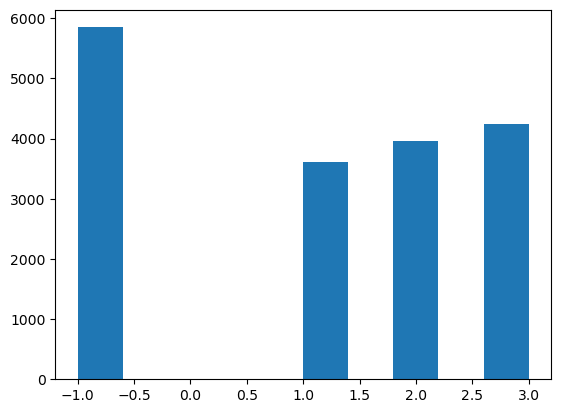

In [13]:
plt.hist(higgs_all)

In [40]:
def get_n_features_v2(arrays, n):
    result = []
    for array in arrays:
        if ak.num(array, axis=0) > n:
            result.append(array[0:n])
        else:
            result.append(array)
    return ak.Array(result)

<Array [[1, 1, 1, 1, 1, 1, ... 0, 0, 1, 0, 0]] type='2112 * var * int64'>

In [41]:
# keep events with >= MIN_JETS small-radius jets
mask_minjets = ak.num(pt[pt > MIN_JET_PT]) >= MIN_JETS
# sort by btag first, then pt
sorted_by_pt = ak.argsort(pt, ascending=False, axis=-1)
sorted = ak.concatenate([sorted_by_pt[btag == 1], sorted_by_pt[btag == 0]], axis=-1)
btag = btag[sorted][mask_minjets]
pt = pt[sorted][mask_minjets]
eta = eta[sorted][mask_minjets]
phi = phi[sorted][mask_minjets]
higgs_idx = higgs_idx[sorted][mask_minjets]
matched_fj_idx = matched_fj_idx[sorted][mask_minjets]

btag = get_n_features_v2(btag, N_JETS)
pt = get_n_features_v2(pt, N_JETS)
eta = get_n_features_v2(eta, N_JETS)
phi = get_n_features_v2(phi, N_JETS)
higgs_idx = get_n_features_v2(higgs_idx, N_JETS)
matched_fj_idx = get_n_features_v2(matched_fj_idx, N_JETS)

# sort by btag first, then pt
sorted_by_fj_pt = ak.argsort(fj_pt, ascending=False, axis=-1)
fj_pt = fj_pt[sorted_by_fj_pt][mask_minjets]
fj_eta = fj_eta[sorted_by_fj_pt][mask_minjets]
fj_phi = fj_phi[sorted_by_fj_pt][mask_minjets]
fj_mass = fj_mass[sorted_by_fj_pt][mask_minjets]
fj_sdmass = fj_sdmass[sorted_by_fj_pt][mask_minjets]
fj_nsub = fj_nsub[sorted_by_fj_pt][mask_minjets]
fj_tau21 = fj_tau21[sorted_by_fj_pt][mask_minjets]
fj_tau32 = fj_tau32[sorted_by_fj_pt][mask_minjets]
fj_area = fj_area[sorted_by_fj_pt][mask_minjets]
fj_charge = fj_charge[sorted_by_fj_pt][mask_minjets]
fj_ptd = fj_ptd[sorted_by_fj_pt][mask_minjets]
fj_ehadovereem = fj_ehadovereem[sorted_by_fj_pt][mask_minjets]
fj_neutralenergyfrac = fj_neutralenergyfrac[sorted_by_fj_pt][mask_minjets]
fj_chargedenergyfrac = fj_chargedenergyfrac[sorted_by_fj_pt][mask_minjets]
fj_nneutral = fj_nneutral[sorted_by_fj_pt][mask_minjets]
fj_ncharged = fj_ncharged[sorted_by_fj_pt][mask_minjets]
fj_higgs_idx = fj_higgs_idx[sorted_by_fj_pt][mask_minjets]


In [43]:
# mask to define zero-padded small-radius jets
mask = pt > MIN_JET_PT

# mask to define zero-padded large-radius jets
fj_mask = fj_pt > MIN_FJET_PT

# index of small-radius jet if Higgs is reconstructed
h1_bs = ak.local_index(higgs_idx)[higgs_idx == 1]
h2_bs = ak.local_index(higgs_idx)[higgs_idx == 2]
h3_bs = ak.local_index(higgs_idx)[higgs_idx == 3]

# index of large-radius jet if Higgs is reconstructed
h1_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 1]
h2_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 2]
h3_bb = ak.local_index(fj_higgs_idx)[fj_higgs_idx == 3]


In [44]:
# check/fix small-radius jet truth (ensure max 2 small-radius jets per higgs)
check = (
    np.unique(ak.count(h1_bs, axis=-1)).to_list()
    + np.unique(ak.count(h2_bs, axis=-1)).to_list()
    + np.unique(ak.count(h3_bs, axis=-1)).to_list()
)
if 3 in check:
    logging.warning("some Higgs bosons match to 3 small-radius jets! Check truth")

# check/fix large-radius jet truth (ensure max 1 large-radius jet per higgs)
fj_check = (
    np.unique(ak.count(h1_bb, axis=-1)).to_list()
    + np.unique(ak.count(h2_bb, axis=-1)).to_list()
    + np.unique(ak.count(h3_bb, axis=-1)).to_list()
)
if 2 in fj_check:
    logging.warning("some Higgs bosons match to 2 large-radius jets! Check truth")

h1_bs = ak.fill_none(ak.pad_none(h1_bs, 2, clip=True), -1)
h2_bs = ak.fill_none(ak.pad_none(h2_bs, 2, clip=True), -1)
h3_bs = ak.fill_none(ak.pad_none(h3_bs, 2, clip=True), -1)

h1_bb = ak.fill_none(ak.pad_none(h1_bb, 1, clip=True), -1)
h2_bb = ak.fill_none(ak.pad_none(h2_bb, 1, clip=True), -1)
h3_bb = ak.fill_none(ak.pad_none(h3_bb, 1, clip=True), -1)

h1_b1, h1_b2 = h1_bs[:, 0], h1_bs[:, 1]
h2_b1, h2_b2 = h2_bs[:, 0], h2_bs[:, 1]
h3_b1, h3_b2 = h3_bs[:, 0], h3_bs[:, 1]

# mask whether Higgs can be reconstructed as 2 small-radius jet
h1_mask = ak.all(h1_bs != -1, axis=-1)
h2_mask = ak.all(h2_bs != -1, axis=-1)
h3_mask = ak.all(h3_bs != -1, axis=-1)

# mask whether Higgs can be reconstructed as 1 large-radius jet
h1_fj_mask = ak.all(h1_bb != -1, axis=-1)
h2_fj_mask = ak.all(h2_bb != -1, axis=-1)
h3_fj_mask = ak.all(h3_bb != -1, axis=-1)

(array([128., 610., 528., 358., 247., 117.,  74.,  32.,  15.,   3.]),
 array([-1. , -0.1,  0.8,  1.7,  2.6,  3.5,  4.4,  5.3,  6.2,  7.1,  8. ]),
 <BarContainer object of 10 artists>)

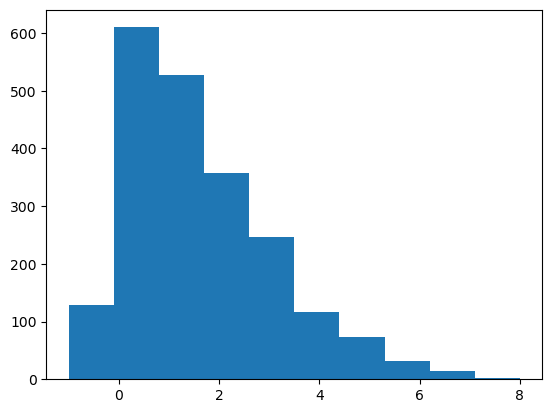

In [46]:
plt.hist(h1_b1)